In [4]:
# import the packages
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import os
import requests
from datetime import datetime
from IPython.display import Image
import matplotlib.pyplot as plt

# import dvc.api

In [5]:
np.random.seed(42)

In [6]:
# set up the display option
pd.set_option('display.max_columns', None)

In [133]:
# install the spark
!bash install_spark.sh


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

Hit:1 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Hi

In [7]:
# set up the spark envrionment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/project/spark-3.2.1-bin-hadoop3.2"

In [21]:
# import spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark App").config("spark.jars", "postgresql-42.3.2.jar").getOrCreate()
spark.conf.set("spark.sql.parquet.enableVectorizedReader","false")

In [22]:
# using BeautifulSoup to get the web page information
URL ="https://www.basketball-reference.com/"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
soup_body = str(soup.body)

In [23]:
# get all the team related data
list_info = re.findall(r'data-stat="payroll_text">(.*)</td></tr>', soup_body)

In [24]:
list_info

['<a href="/contracts/MIA.html" title="Miami Heat Team Payroll">$</a></td><td class="right" data-stat="wins">53</td><td class="right" data-stat="losses">29',
 '<a href="/contracts/BOS.html" title="Boston Celtics Team Payroll">$</a></td><td class="right" data-stat="wins">51</td><td class="right" data-stat="losses">31',
 '<a href="/contracts/MIL.html" title="Milwaukee Bucks Team Payroll">$</a></td><td class="right" data-stat="wins">51</td><td class="right" data-stat="losses">31',
 '<a href="/contracts/PHI.html" title="Philadelphia 76ers Team Payroll">$</a></td><td class="right" data-stat="wins">51</td><td class="right" data-stat="losses">31',
 '<a href="/contracts/TOR.html" title="Toronto Raptors Team Payroll">$</a></td><td class="right" data-stat="wins">48</td><td class="right" data-stat="losses">34',
 '<a href="/contracts/CHI.html" title="Chicago Bulls Team Payroll">$</a></td><td class="right" data-stat="wins">46</td><td class="right" data-stat="losses">36',
 '<a href="/contracts/BRK.h

In [25]:
# set the team code and their full name into a dictionary
dict_info = {i[20:23]:[re.findall(r'title="(.*) Team Payroll', i)[0], int(re.findall(r'data-stat="wins">(.*)</', i)[0]), int(re.findall(r'data-stat="losses">(.*)', i)[0])] for i in list_info}

In [26]:
# check the playoff data
URL ="https://www.basketball-reference.com/playoffs/NBA_2022.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
soup_body = str(soup.body)

In [27]:
# get the playoff team name
list_playoff = [i.split("html'>")[1] for i in re.findall(r'data-stat="team" >(.*?)</a></td><td', soup_body)]

In [28]:
list_playoff

['Golden State Warriors',
 'Philadelphia 76ers',
 'Boston Celtics',
 'Phoenix Suns',
 'Dallas Mavericks',
 'New Orleans Pelicans',
 'Utah Jazz',
 'Brooklyn Nets',
 'Miami Heat',
 'Denver Nuggets',
 'Toronto Raptors',
 'Memphis Grizzlies',
 'Milwaukee Bucks',
 'Minnesota Timberwolves',
 'Atlanta Hawks',
 'Chicago Bulls',
 'Milwaukee Bucks',
 'Miami Heat',
 'Memphis Grizzlies',
 'Chicago Bulls',
 'Minnesota Timberwolves',
 'Philadelphia 76ers',
 'Golden State Warriors',
 'Atlanta Hawks',
 'Boston Celtics',
 'Dallas Mavericks',
 'Phoenix Suns',
 'Utah Jazz',
 'New Orleans Pelicans',
 'Brooklyn Nets',
 'Toronto Raptors',
 'Denver Nuggets',
 'Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Chicago Bulls',
 'Dallas Mavericks',
 'Denver Nuggets',
 'Golden State Warriors',
 'Memphis Grizzlies',
 'Miami Heat',
 'Milwaukee Bucks',
 'Minnesota Timberwolves',
 'New Orleans Pelicans',
 'Philadelphia 76ers',
 'Phoenix Suns',
 'Toronto Raptors',
 'Utah Jazz',
 'Atlanta Hawks',
 'Boston Celtics

In [29]:
# convert the team data into a data frame
team_df = pd.DataFrame({'team': dict_info.keys(), 'name': [i[0] for i in dict_info.values()], 'win': [int(i[1]) for i in dict_info.values()], 'loss': [int(i[2]) for i in dict_info.values()]})

In [30]:
# match all the playoff information with the data frame
list_in_playoff = [1 if i in list_playoff else 0 for i in team_df.name]

In [31]:
# add the column of  in_playoff into the data frame for team information
team_df['in_playoff'] = list_in_playoff

In [33]:
# convert the team information into spark data frame
df_team = spark.createDataFrame(team_df)

In [34]:
# show the schema of the data frame
df_team.printSchema()

root
 |-- team: string (nullable = true)
 |-- name: string (nullable = true)
 |-- win: long (nullable = true)
 |-- loss: long (nullable = true)
 |-- in_playoff: long (nullable = true)



In [35]:
# convert the data frame into parquet format
df_team.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/team.parquet", mode = 'overwrite')

# players

In [36]:
# read the parquet file for team df
team_df = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/team.parquet").toPandas()

In [410]:
# create a data frame to store each player's information
players = pd.DataFrame(columns = ['name', 'link','is_eastern', 'No.', 'pos', 'height', 'weight', 'birth', 'age'])

In [411]:
players

,name,link,is_eastern,No.,pos,height,weight,birth,age


In [412]:
# loop through each team page and get all the players in each team and their related information
for t in team_df.team:
    URL =f"https://www.basketball-reference.com/teams/{t}/2022.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    soup_body = str(soup.body)
    
    no = [i for i in re.findall(r'data-stat="number" scope="row">(.*)</th>', soup_body)]
    link_name = [i.split('</a>')[0].split('">') for i in re.findall(r'"><a href="(.*?)data-stat="pos"', soup_body)]
    pos = re.findall(r'data-stat="pos">(.*?)</td>', soup_body)
    height = [float(i.replace('-', '.')) for i in re.findall(r'data-stat="height">(.*?)</td>', soup_body)]
    weight = [int(i) for i in re.findall(r'data-stat="weight">(.*?)</td>', soup_body)]
    birth = re.findall(r'</td><td class="left" csk="(.*)" data-stat="birth_date">', soup_body)
    exp = re.findall(r'data-stat="years_experience">(.*)</td><td class', soup_body)
    list_team = [t for i in range(len(no))]
    playoff = team_df[team_df['team'] == t]['in_playoff'].values[0]
    list_playoff_t = [int(playoff) for i in range(len(no))]
    is_eastern = [1 if 'Eastern' in re.findall(r'>NBA</a> \n(.*)\n', soup_body)[0] else 0 for i in range(len(no))]
    
    players = players.append(pd.DataFrame({'team': list_team,'playoff': list_playoff_t, 'name': [i[1] for i in link_name], 'link': [i[0] for i in link_name], 'No.': no, 'pos': pos, 'height': height, 'weight': weight, 'birth':[int(i[:4]) for i in birth], 'exp': exp, 'is_eastern':is_eastern})).reset_index(drop=True)

In [414]:
# convert the experience information with 'R' to 0.5 and convert the data type into float64
players['exp'] = players['exp'].replace('R', 0.5)
players['exp'] = players['exp'].astype(np.float64)

In [415]:
# temporary lists for all the players' information
temp_in_season = []
temp_list_2122 = []
temp_list_career = []
# loop through each player's page and get their game information
for count,l in enumerate(players.link):
    URL =f"https://www.basketball-reference.com{l}"
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, "html.parser")
    soup_body = str(soup.body)
    
    
    temp_in_season.append('gamelog/2022' in soup_body)
    temp_list_2122.append(re.findall(fr'{l[1:-5]}/gamelog/2022">(.*?)</td></tr> ', soup_body))
    temp_list_career.append(re.findall(r'</tbody><tfoot><tr><th class="left" data-stat="season" scope="row">Career(.*?)</td></tr>', soup_body))
# add the columns into the players data frame
players['in_2021_22_season'] = temp_in_season
players['2021_2022_season'] = temp_list_2122
players['career'] = temp_list_career

In [416]:
temp_dict = {}
# loop through the teams and get each player's guarantee
for t in team_df.team:
    
    URL =f"https://www.basketball-reference.com/contracts/{t}.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    soup_body = str(soup.body)
    for i in re.findall(r'data-stat="player"(.*)</td></tr>', soup_body):
        if '.html">' in i and 'scope="row"><em>' not in i:
            temp_dict[re.findall(r'html">(.*)</a>', i)[0]] = re.findall(r'data-stat="remain_gtd">\$(.*)', i)
players = players.merge(pd.DataFrame({'name': temp_dict.keys(), 'guaranteed': temp_dict.values()}), how = 'left', on = 'name')

In [417]:
# fill all na
players = players.replace((np.inf, -np.inf, np.nan), '0').reset_index(drop = True)

In [418]:
# convert the list into int
players['guaranteed'] = players['guaranteed'].apply(lambda x: int(x[0].replace(',','')) if len(x)>0 else 0)

In [419]:
# get the age of each player by 2022-birth year
players['age'] = players['birth'].apply(lambda x: 2022 - int(x))

In [420]:
# fill the empty information 
players['2021_2022_season'] = players['2021_2022_season'].apply(lambda x: x[0] if len(x) > 0 else '0')
players['career'] = players['career'].apply(lambda x: x[0] if len(x) > 0 else '0')

In [421]:
players

,name,link,is_eastern,No.,pos,height,weight,birth,age,team,playoff,exp,in_2021_22_season,2021_2022_season,career,guaranteed
0,Duncan Robinson,/players/r/robindu01.html,1,55,SG,6.7,215,1994,28,MIA,1.0,3.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",79910000
1,P.J. Tucker,/players/t/tuckepj01.html,1,17,PF,6.5,245,1985,37,MIA,1.0,10.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",7000000
2,Max Strus,/players/s/strusma01.html,1,31,SF,6.5,215,1996,26,MIA,1.0,2.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",1669178
3,Gabe Vincent,/players/v/vincega01.html,1,2,PG,6.3,200,1996,26,MIA,1.0,2.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",1669178
4,Dewayne Dedmon,/players/d/dedmode01.html,1,21,C,7.0,245,1989,33,MIA,1.0,8.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",2389641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,Dennis Schröder,/players/s/schrode01.html,0,17,PG,6.3,172,1993,29,HOU,0.0,8.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",5890000
504,Bruno Fernando,/players/f/fernabr01.html,0,20,C,6.9,240,1998,24,HOU,0.0,2.0,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",1782621
505,Trevelin Queen,/players/q/queentr01.html,0,21,SG,6.6,190,1997,25,HOU,0.0,0.5,True,"2021-22</a></th><td class=""center"" data-stat=""...","</th><td class=""center iz"" data-stat=""age""></t...",0
506,John Wall,/players/w/walljo01.html,0,0,PG,6.3,210,1990,32,HOU,0.0,10.0,False,0,"</th><td class=""center iz"" data-stat=""age""></t...",44310840


In [422]:
def get_info(pattern, list_info):
    '''
    function to get information for different attributes
    '''
    temp_list = []
    for count, i in enumerate(list_info):
        if i!='0':
            result = re.findall(pattern, i)[0]
            if 'strong' in result:
                result = result.replace('strong','').replace('/','').replace('<','').replace('>','')
            if result == '':
                result = 0
            
            temp_list.append(result)
        else:
            temp_list.append(0)
    return temp_list

In [423]:
# create new columns and get the corresponding information and convert the data type
players['G_2122'] = get_info((r'data-stat="g">(.*?)</td'), players['2021_2022_season'])
players['G_2122'] = players['G_2122'].astype(np.int64)
players['GS_2122'] = get_info((r'data-stat="gs">(.*?)</td'), players['2021_2022_season'])
players['GS_2122'] = players['GS_2122'].astype(np.int64)
players['MP_2122'] = get_info((r'data-stat="mp_per_g">(.*?)</td'), players['2021_2022_season'])
players['MP_2122'] = players['MP_2122'].astype(np.float64)
players['FG%_2122'] = get_info((r'data-stat="fg_pct">(.*?)</td'), players['2021_2022_season'])
players['FG%_2122'] = players['FG%_2122'].astype(np.float64)
players['3P%_2122'] = get_info((r'data-stat="fg3_pct">(.*?)</td'), players['2021_2022_season'])
players['3P%_2122'] = players['3P%_2122'].astype(np.float64)
players['2P%_2122'] = get_info((r'data-stat="fg2_pct">(.*?)</td'), players['2021_2022_season'])
players['2P%_2122'] = players['2P%_2122'].astype(np.float64)
players['eFG%_2122'] = get_info((r'data-stat="efg_pct">(.*?)</td'), players['2021_2022_season'])
players['eFG%_2122'] = players['eFG%_2122'].astype(np.float64)
players['FT%_2122'] = get_info((r'data-stat="ft_pct">(.*?)</td'), players['2021_2022_season'])
players['FT%_2122'] = players['FT%_2122'].astype(np.float64)
players['ORB_2122'] = get_info((r'data-stat="orb_per_g">(.*?)</td'), players['2021_2022_season'])
players['ORB_2122'] = players['ORB_2122'].astype(np.float64)
players['DRB_2122'] = get_info((r'data-stat="drb_per_g">(.*?)</td'), players['2021_2022_season'])
players['DRB_2122'] = players['DRB_2122'].astype(np.float64)
players['AST_2122'] = get_info((r'data-stat="ast_per_g">(.*?)</td'), players['2021_2022_season'])
players['AST_2122'] = players['AST_2122'].astype(np.float64)
players['STL_2122'] = get_info((r'data-stat="stl_per_g">(.*?)</td'), players['2021_2022_season'])
players['STL_2122'] = players['STL_2122'].astype(np.float64)
players['BLK_2122'] = get_info((r'data-stat="blk_per_g">(.*?)</td'), players['2021_2022_season'])
players['BLK_2122'] = players['BLK_2122'].astype(np.float64)
players['TOV_2122'] = get_info((r'data-stat="tov_per_g">(.*?)</td'), players['2021_2022_season'])
players['TOV_2122'] = players['TOV_2122'].astype(np.float64)
players['PF_2122'] = get_info((r'data-stat="pf_per_g">(.*?)</td'), players['2021_2022_season'])
players['PF_2122'] = players['PF_2122'].astype(np.float64)
players['PTS_2122'] = get_info((r'data-stat="pts_per_g">(.*)'), players['2021_2022_season'])
players['PTS_2122'] = players['PTS_2122'].astype(np.float64)

In [424]:
# create new columns and get the corresponding information and convert the data type
players['G_career'] = get_info((r'data-stat="g">(.*?)</td'), players['career'])
players['G_career'] = players['G_career'].astype(np.int64)
players['GS_career'] = get_info((r'data-stat="gs">(.*?)</td'), players['career'])
players['GS_career'] = players['GS_career'].astype(np.int64)
players['MP_career'] = get_info((r'data-stat="mp_per_g">(.*?)</td'), players['career'])
players['MP_career'] = players['MP_career'].astype(np.float64)
players['FG%_career'] = get_info((r'data-stat="fg_pct">(.*?)</td'), players['career'])
players['FG%_career'] = players['FG%_career'].astype(np.float64)
players['3P%_career'] = get_info((r'data-stat="fg3_pct">(.*?)</td'), players['career'])
players['3P%_career'] = players['3P%_career'].astype(np.float64)
players['2P%_career'] = get_info((r'data-stat="fg2_pct">(.*?)</td'), players['career'])
players['2P%_career'] = players['2P%_career'].astype(np.float64)
players['eFG%_career'] = get_info((r'data-stat="efg_pct">(.*?)</td'), players['career'])
players['eFG%_career'] = players['eFG%_career'].astype(np.float64)
players['FT%_career'] = get_info((r'data-stat="ft_pct">(.*?)</td'), players['career'])
players['FT%_career'] = players['FT%_career'].astype(np.float64)
players['ORB_career'] = get_info((r'data-stat="orb_per_g">(.*?)</td'), players['career'])
players['ORB_career'] = players['ORB_career'].astype(np.float64)
players['DRB_career'] = get_info((r'data-stat="drb_per_g">(.*?)</td'), players['career'])
players['DRB_career'] = players['DRB_career'].astype(np.float64)
players['AST_career'] = get_info((r'data-stat="ast_per_g">(.*?)</td'), players['career'])
players['AST_career'] = players['AST_career'].astype(np.float64)
players['STL_career'] = get_info((r'data-stat="stl_per_g">(.*?)</td'), players['career'])
players['STL_career'] = players['STL_career'].astype(np.float64)
players['BLK_career'] = get_info((r'data-stat="blk_per_g">(.*?)</td'), players['career'])
players['BLK_career'] = players['BLK_career'].astype(np.float64)
players['TOV_career'] = get_info((r'data-stat="tov_per_g">(.*?)</td'), players['career'])
players['TOV_career'] = players['TOV_career'].astype(np.float64)
players['PF_career'] = get_info((r'data-stat="pf_per_g">(.*?)</td'), players['career'])
players['PF_career'] = players['PF_career'].astype(np.float64)
players['PTS_career'] = get_info((r'data-stat="pts_per_g">(.*)'), players['career'])
players['PTS_career'] = players['PTS_career'].astype(np.float64)

In [439]:
players = players.drop(['2021_2022_season', 'career'], axis = 1)

In [440]:
# convert the players data into spark data frame
players_df = spark.createDataFrame(players)

In [441]:
# show the schema of the spark data frame
players_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- link: string (nullable = true)
 |-- is_eastern: long (nullable = true)
 |-- No.: long (nullable = true)
 |-- pos: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: long (nullable = true)
 |-- birth: long (nullable = true)
 |-- age: long (nullable = true)
 |-- team: string (nullable = true)
 |-- playoff: double (nullable = true)
 |-- exp: double (nullable = true)
 |-- in_2021_22_season: boolean (nullable = true)
 |-- guaranteed: long (nullable = true)
 |-- G_2122: long (nullable = true)
 |-- GS_2122: long (nullable = true)
 |-- MP_2122: double (nullable = true)
 |-- FG%_2122: double (nullable = true)
 |-- 3P%_2122: double (nullable = true)
 |-- 2P%_2122: double (nullable = true)
 |-- eFG%_2122: double (nullable = true)
 |-- FT%_2122: double (nullable = true)
 |-- ORB_2122: double (nullable = true)
 |-- DRB_2122: double (nullable = true)
 |-- AST_2122: double (nullable = true)
 |-- STL_2122: double (nullable = true)


In [442]:
# convert the data frame into parquet format
players_df.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet", mode = 'overwrite')

# prepare the data for ml

In [444]:
# load the data from parquet file
players = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet").toPandas()

Py4JJavaError: An error occurred while calling o518.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 42.0 failed 1 times, most recent failure: Lost task 2.0 in stage 42.0 (TID 131) (cube-947c070f-6886-4760-a220-34ba7138c2ea-55857f4c97-jh6jw executor driver): org.apache.spark.sql.execution.QueryExecutionException: Parquet column cannot be converted in file file:///project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet/part-00003-8c256eb3-c241-4115-8262-5e6e46ea5c28-c000.snappy.parquet. Column: [No.], Expected: bigint, Found: BINARY
	at org.apache.spark.sql.errors.QueryExecutionErrors$.unsupportedSchemaColumnConvertError(QueryExecutionErrors.scala:570)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:195)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.sql.execution.datasources.SchemaColumnConvertNotSupportedException
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.constructConvertNotSupportedException(ParquetVectorUpdaterFactory.java:1104)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.getUpdater(ParquetVectorUpdaterFactory.java:181)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:161)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:298)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:196)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:191)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:394)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.sql.execution.QueryExecutionException: Parquet column cannot be converted in file file:///project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet/part-00003-8c256eb3-c241-4115-8262-5e6e46ea5c28-c000.snappy.parquet. Column: [No.], Expected: bigint, Found: BINARY
	at org.apache.spark.sql.errors.QueryExecutionErrors$.unsupportedSchemaColumnConvertError(QueryExecutionErrors.scala:570)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:195)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.sql.execution.datasources.SchemaColumnConvertNotSupportedException
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.constructConvertNotSupportedException(ParquetVectorUpdaterFactory.java:1104)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.getUpdater(ParquetVectorUpdaterFactory.java:181)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:161)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:298)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:196)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:191)
	... 20 more


In [409]:
players

,is_eastern,height,weight,birth,age,playoff,exp,in_2021_22_season,guaranteed,G_2122,GS_2122,MP_2122,FG%_2122,3P%_2122,2P%_2122,eFG%_2122,FT%_2122,ORB_2122,DRB_2122,AST_2122,STL_2122,BLK_2122,TOV_2122,PF_2122,PTS_2122,G_career,GS_career,MP_career,FG%_career,3P%_career,2P%_career,eFG%_career,FT%_career,ORB_career,DRB_career,AST_career,STL_career,BLK_career,TOV_career,PF_career,PTS_career,is_C,is_PF,is_PG,is_SF,is_SG
338,0,6.80,235,1995,27,1.0,7.0,1,80207637,75,75,31.7,0.520,0.335,0.605,0.573,0.743,1.7,4.2,2.5,0.6,0.6,1.8,2.0,15.0,528,439,28.9,0.460,0.323,0.525,0.512,0.702,1.6,4.7,2.5,0.7,0.6,1.5,2.0,13.0,0,1,0,0,0
267,0,6.00,185,1996,26,1.0,3.0,1,3980551,63,15,16.2,0.447,0.379,0.477,0.504,0.868,0.4,1.6,2.4,0.7,0.1,1.1,1.5,6.3,245,56,18.2,0.412,0.373,0.438,0.486,0.840,0.3,1.5,2.4,0.7,0.2,1.1,1.5,7.3,0,0,1,0,0
24,1,6.50,215,1999,23,1.0,1.0,1,7435560,52,3,11.0,0.396,0.270,0.612,0.481,0.808,0.3,1.4,0.4,0.4,0.1,0.6,1.3,3.8,98,4,12.7,0.417,0.318,0.577,0.515,0.796,0.4,1.8,0.5,0.4,0.1,0.6,1.6,4.2,0,0,0,1,0
480,0,6.60,200,1999,23,0.0,0.5,1,1000000,50,35,24.2,0.463,0.304,0.573,0.525,0.729,1.0,2.5,1.4,0.6,0.2,1.1,1.9,8.3,50,35,24.2,0.463,0.304,0.573,0.525,0.729,1.0,2.5,1.4,0.6,0.2,1.1,1.9,8.3,0,0,0,0,1
248,1,6.50,241,1997,25,0.0,1.0,1,169706,38,1,12.3,0.419,0.329,0.560,0.519,0.800,0.4,1.9,0.7,0.1,0.1,0.6,1.5,3.8,71,3,11.8,0.403,0.321,0.543,0.505,0.733,0.3,1.6,0.6,0.2,0.1,0.4,1.5,3.5,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,6.11,250,1997,25,0.0,3.0,1,22000000,28,4,17.9,0.490,0.341,0.544,0.535,0.800,1.6,3.8,2.2,0.5,0.8,1.6,2.4,7.8,182,16,17.5,0.452,0.327,0.511,0.504,0.743,1.2,3.0,1.1,0.3,0.7,1.1,2.3,6.0,0,1,0,0,0
88,1,6.50,200,1995,27,1.0,7.0,1,19500000,67,67,34.7,0.476,0.389,0.534,0.554,0.853,0.3,4.3,4.5,0.6,0.3,2.6,1.8,24.4,478,391,31.8,0.461,0.386,0.504,0.531,0.830,0.5,3.5,3.9,0.9,0.3,2.7,2.2,19.8,0,0,0,1,0
348,0,6.90,240,2001,21,1.0,1.0,1,5116560,41,1,17.0,0.516,0.463,0.557,0.616,0.631,1.4,2.2,0.4,0.4,0.3,0.6,1.9,6.6,83,2,13.2,0.503,0.439,0.563,0.609,0.663,0.8,1.7,0.3,0.3,0.2,0.4,1.3,4.9,0,1,0,0,0
278,0,6.80,215,2001,21,1.0,0.5,1,8965080,62,31,21.7,0.450,0.314,0.632,0.540,0.782,0.4,1.7,1.0,0.6,0.2,0.7,1.8,8.1,62,31,21.7,0.450,0.314,0.632,0.540,0.782,0.4,1.7,1.0,0.6,0.2,0.7,1.8,8.1,0,0,0,1,0


In [366]:
# convert the categorecal data into dummies
dummies_df = pd.get_dummies(players['pos'], prefix='is')

In [367]:
# add the columns into the data frame
for c in dummies_df.columns:
    players[c] = list(dummies_df[c])

In [368]:
# convert from True/False to 1/0
players['in_2021_22_season'] = players['in_2021_22_season'].replace({True:1, False:0})

In [373]:
players = players.sort_values('name')

In [374]:
# drop the columns that are not used for machine learning
players = players.drop(['2021_2022_season', 'career', 'team', 'name', 'link', 'pos', 'No.'], axis = 1)

In [375]:
players

,is_eastern,height,weight,birth,age,playoff,exp,in_2021_22_season,guaranteed,G_2122,GS_2122,MP_2122,FG%_2122,3P%_2122,2P%_2122,eFG%_2122,FT%_2122,ORB_2122,DRB_2122,AST_2122,STL_2122,BLK_2122,TOV_2122,PF_2122,PTS_2122,G_career,GS_career,MP_career,FG%_career,3P%_career,2P%_career,eFG%_career,FT%_career,ORB_career,DRB_career,AST_career,STL_career,BLK_career,TOV_career,PF_career,PTS_career,is_C,is_PF,is_PG,is_SF,is_SG
338,0,6.80,235,1995,27,1.0,7.0,1,80207637,75,75,31.7,0.520,0.335,0.605,0.573,0.743,1.7,4.2,2.5,0.6,0.6,1.8,2.0,15.0,528,439,28.9,0.460,0.323,0.525,0.512,0.702,1.6,4.7,2.5,0.7,0.6,1.5,2.0,13.0,0,1,0,0,0
267,0,6.00,185,1996,26,1.0,3.0,1,3980551,63,15,16.2,0.447,0.379,0.477,0.504,0.868,0.4,1.6,2.4,0.7,0.1,1.1,1.5,6.3,245,56,18.2,0.412,0.373,0.438,0.486,0.840,0.3,1.5,2.4,0.7,0.2,1.1,1.5,7.3,0,0,1,0,0
24,1,6.50,215,1999,23,1.0,1.0,1,7435560,52,3,11.0,0.396,0.270,0.612,0.481,0.808,0.3,1.4,0.4,0.4,0.1,0.6,1.3,3.8,98,4,12.7,0.417,0.318,0.577,0.515,0.796,0.4,1.8,0.5,0.4,0.1,0.6,1.6,4.2,0,0,0,1,0
480,0,6.60,200,1999,23,0.0,0.5,1,1000000,50,35,24.2,0.463,0.304,0.573,0.525,0.729,1.0,2.5,1.4,0.6,0.2,1.1,1.9,8.3,50,35,24.2,0.463,0.304,0.573,0.525,0.729,1.0,2.5,1.4,0.6,0.2,1.1,1.9,8.3,0,0,0,0,1
248,1,6.50,241,1997,25,0.0,1.0,1,169706,38,1,12.3,0.419,0.329,0.560,0.519,0.800,0.4,1.9,0.7,0.1,0.1,0.6,1.5,3.8,71,3,11.8,0.403,0.321,0.543,0.505,0.733,0.3,1.6,0.6,0.2,0.1,0.4,1.5,3.5,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,6.11,250,1997,25,0.0,3.0,1,22000000,28,4,17.9,0.490,0.341,0.544,0.535,0.800,1.6,3.8,2.2,0.5,0.8,1.6,2.4,7.8,182,16,17.5,0.452,0.327,0.511,0.504,0.743,1.2,3.0,1.1,0.3,0.7,1.1,2.3,6.0,0,1,0,0,0
88,1,6.50,200,1995,27,1.0,7.0,1,19500000,67,67,34.7,0.476,0.389,0.534,0.554,0.853,0.3,4.3,4.5,0.6,0.3,2.6,1.8,24.4,478,391,31.8,0.461,0.386,0.504,0.531,0.830,0.5,3.5,3.9,0.9,0.3,2.7,2.2,19.8,0,0,0,1,0
348,0,6.90,240,2001,21,1.0,1.0,1,5116560,41,1,17.0,0.516,0.463,0.557,0.616,0.631,1.4,2.2,0.4,0.4,0.3,0.6,1.9,6.6,83,2,13.2,0.503,0.439,0.563,0.609,0.663,0.8,1.7,0.3,0.3,0.2,0.4,1.3,4.9,0,1,0,0,0
278,0,6.80,215,2001,21,1.0,0.5,1,8965080,62,31,21.7,0.450,0.314,0.632,0.540,0.782,0.4,1.7,1.0,0.6,0.2,0.7,1.8,8.1,62,31,21.7,0.450,0.314,0.632,0.540,0.782,0.4,1.7,1.0,0.6,0.2,0.7,1.8,8.1,0,0,0,1,0


In [376]:
import yaml
from sklearn.model_selection import train_test_split
# load the yaml document
params = yaml.safe_load(open("/project/MSIN0166_Data_Engineering_individual/params.yaml"))["ML"]

In [377]:
params

{'split': 0.2, 'seed': 42, 'shuffle': True, 'n_components': 10}

In [378]:
# split the train and test sets
players_train, players_test = train_test_split(players, test_size = params['split'], shuffle = params['shuffle'], random_state = params['seed'])

In [379]:
players_train

,is_eastern,height,weight,birth,age,playoff,exp,in_2021_22_season,guaranteed,G_2122,GS_2122,MP_2122,FG%_2122,3P%_2122,2P%_2122,eFG%_2122,FT%_2122,ORB_2122,DRB_2122,AST_2122,STL_2122,BLK_2122,TOV_2122,PF_2122,PTS_2122,G_career,GS_career,MP_career,FG%_career,3P%_career,2P%_career,eFG%_career,FT%_career,ORB_career,DRB_career,AST_career,STL_career,BLK_career,TOV_career,PF_career,PTS_career,is_C,is_PF,is_PG,is_SF,is_SG
370,0,6.0,196,1998,24,1.0,0.5,1,0,5,0,3.8,0.667,0.500,1.000,0.833,0.000,0.0,0.0,0.6,0.0,0.0,0.2,0.2,1.0,5,0,3.8,0.667,0.500,1.000,0.833,0.000,0.0,0.0,0.6,0.0,0.0,0.2,0.2,1.0,0,0,1,0,0
127,1,6.6,196,1996,26,0.0,1.0,1,6276478,50,0,9.2,0.378,0.300,0.571,0.485,0.833,0.4,1.4,0.7,0.3,0.1,0.3,0.9,2.2,81,0,12.0,0.412,0.320,0.580,0.515,0.800,0.5,1.9,0.8,0.4,0.2,0.6,1.0,3.3,0,0,0,1,0
13,1,6.8,235,1980,42,1.0,18.0,1,2641691,13,0,6.4,0.452,0.250,0.481,0.468,1.000,0.3,1.6,0.3,0.1,0.1,0.4,1.2,2.5,872,500,24.8,0.489,0.097,0.494,0.490,0.756,1.8,4.8,0.8,0.5,0.3,0.9,2.4,7.5,1,0,0,0,0
448,0,6.4,201,1997,25,0.0,2.0,1,8000000,30,11,17.9,0.423,0.329,0.542,0.515,0.818,0.4,2.8,1.3,0.8,0.4,1.1,2.3,10.4,163,19,17.3,0.437,0.366,0.531,0.541,0.835,0.5,2.5,1.5,0.7,0.2,1.1,1.8,8.5,0,0,0,0,1
218,1,6.2,190,1990,32,0.0,10.0,1,17809524,34,8,28.5,0.363,0.339,0.380,0.434,0.854,0.4,3.7,6.6,1.4,0.2,2.6,2.2,13.1,665,601,30.3,0.389,0.326,0.417,0.439,0.843,0.6,3.5,7.6,1.8,0.1,2.6,2.5,11.1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,6.6,220,1989,33,1.0,12.0,1,81900000,76,76,36.1,0.504,0.352,0.520,0.521,0.877,0.7,4.4,4.9,0.9,0.3,2.4,2.3,27.9,957,945,34.3,0.465,0.288,0.483,0.478,0.837,0.7,3.7,3.9,1.0,0.3,2.1,2.3,20.8,0,1,0,0,0
33,1,6.7,232,1997,25,1.0,2.0,1,115116,2,0,15.5,0.667,0.500,1.000,0.833,0.000,1.0,1.0,0.5,0.0,0.0,0.0,1.5,2.5,52,0,6.0,0.525,0.348,0.639,0.593,0.545,0.4,0.8,0.3,0.1,0.1,0.2,0.8,1.5,0,1,0,0,0
490,0,6.5,215,1996,26,0.0,2.0,1,0,3,0,40.0,0.271,0.048,0.444,0.281,0.714,1.7,2.7,0.3,0.3,0.0,1.0,2.7,10.7,32,0,9.1,0.340,0.209,0.433,0.383,0.533,0.3,0.6,0.2,0.3,0.1,0.3,0.8,2.7,0,0,0,0,1
476,0,6.6,180,1998,24,0.0,3.0,1,178045532,56,56,34.7,0.453,0.300,0.514,0.496,0.810,0.7,4.3,5.9,1.3,0.8,2.8,2.5,24.5,243,234,31.8,0.473,0.348,0.516,0.517,0.807,0.7,3.8,4.3,1.1,0.7,2.2,2.1,18.2,0,0,1,0,0


In [380]:
# extract the columns for transformation
players_train_trans = pd.DataFrame(players_train[players_train.columns[9:-5]])
players_test_trans = pd.DataFrame(players_test[players_test.columns[9:-5]])
X_train = np.array(players_train_trans)
X_test = np.array(players_test_trans) 

In [381]:
from sklearn.preprocessing import StandardScaler
# standardise the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [382]:
from sklearn.decomposition import PCA
# get the first 10 pca components
pca_train = PCA(n_components=params['n_components'])
pca_test = PCA(n_components = params ['n_components'])
pca_train.fit(X_train)
pca_test.fit(X_test)
players_pca_train= pca_train.transform(X_train)
players_pca_test= pca_test.transform(X_test)

In [383]:
sum(pca_train.explained_variance_ratio_)

0.9112038798252212

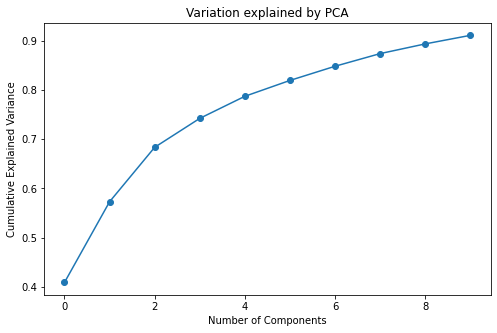

In [384]:
# plot the PCA variation
plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca_train.explained_variance_ratio_),linestyle='solid', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variation explained by PCA')

plt.show()

In [385]:
# convert the pca result into data frame
pca_players_train_df = pd.DataFrame(players_pca_train)
pca_players_test_df = pd.DataFrame(players_pca_test)

In [386]:
pca_players_test_df

,0,1,2,3,4,5,6,7,8,9
0,0.452547,-1.480272,-1.504446,-0.201428,-0.359760,1.450016,0.000376,-0.019747,0.107735,0.330263
1,4.717625,-2.553937,-0.041341,0.946361,1.857862,0.118589,2.859152,-0.324435,0.939196,-0.259990
2,-3.053235,6.817991,0.615137,-3.573132,2.971517,-0.350997,-0.418179,0.498331,-0.779222,0.787800
3,1.462814,-0.499462,4.121996,-1.377212,-2.541719,2.613014,0.391366,-1.219112,0.085761,-0.511671
4,-1.407968,2.854372,0.003395,0.633337,0.276707,0.130246,0.453676,-0.811405,-0.044182,0.383002
...,...,...,...,...,...,...,...,...,...,...
97,-8.640796,-2.283411,2.823968,4.589222,4.354408,2.001849,-1.172413,0.121335,-0.946883,0.906124
98,-0.872953,-2.183884,-0.254797,0.190111,0.436363,1.917431,0.476334,0.331577,0.338003,0.331242
99,-2.089898,0.186254,-1.567941,-0.854542,-0.019603,-0.973691,0.748062,-0.174169,0.513056,0.541399
100,-4.982270,-1.923844,1.859407,-0.001345,-0.716804,-0.694622,0.841254,-0.560213,0.597453,0.419882


In [387]:
# rename the columns
pca_players_train_df.columns = [f'PCA{i+1}' for i in pca_players_train_df.columns]
pca_players_test_df.columns = [f'PCA{i+1}' for i in pca_players_test_df.columns]

In [388]:
players_train

,is_eastern,height,weight,birth,age,playoff,exp,in_2021_22_season,guaranteed,G_2122,GS_2122,MP_2122,FG%_2122,3P%_2122,2P%_2122,eFG%_2122,FT%_2122,ORB_2122,DRB_2122,AST_2122,STL_2122,BLK_2122,TOV_2122,PF_2122,PTS_2122,G_career,GS_career,MP_career,FG%_career,3P%_career,2P%_career,eFG%_career,FT%_career,ORB_career,DRB_career,AST_career,STL_career,BLK_career,TOV_career,PF_career,PTS_career,is_C,is_PF,is_PG,is_SF,is_SG
370,0,6.0,196,1998,24,1.0,0.5,1,0,5,0,3.8,0.667,0.500,1.000,0.833,0.000,0.0,0.0,0.6,0.0,0.0,0.2,0.2,1.0,5,0,3.8,0.667,0.500,1.000,0.833,0.000,0.0,0.0,0.6,0.0,0.0,0.2,0.2,1.0,0,0,1,0,0
127,1,6.6,196,1996,26,0.0,1.0,1,6276478,50,0,9.2,0.378,0.300,0.571,0.485,0.833,0.4,1.4,0.7,0.3,0.1,0.3,0.9,2.2,81,0,12.0,0.412,0.320,0.580,0.515,0.800,0.5,1.9,0.8,0.4,0.2,0.6,1.0,3.3,0,0,0,1,0
13,1,6.8,235,1980,42,1.0,18.0,1,2641691,13,0,6.4,0.452,0.250,0.481,0.468,1.000,0.3,1.6,0.3,0.1,0.1,0.4,1.2,2.5,872,500,24.8,0.489,0.097,0.494,0.490,0.756,1.8,4.8,0.8,0.5,0.3,0.9,2.4,7.5,1,0,0,0,0
448,0,6.4,201,1997,25,0.0,2.0,1,8000000,30,11,17.9,0.423,0.329,0.542,0.515,0.818,0.4,2.8,1.3,0.8,0.4,1.1,2.3,10.4,163,19,17.3,0.437,0.366,0.531,0.541,0.835,0.5,2.5,1.5,0.7,0.2,1.1,1.8,8.5,0,0,0,0,1
218,1,6.2,190,1990,32,0.0,10.0,1,17809524,34,8,28.5,0.363,0.339,0.380,0.434,0.854,0.4,3.7,6.6,1.4,0.2,2.6,2.2,13.1,665,601,30.3,0.389,0.326,0.417,0.439,0.843,0.6,3.5,7.6,1.8,0.1,2.6,2.5,11.1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,6.6,220,1989,33,1.0,12.0,1,81900000,76,76,36.1,0.504,0.352,0.520,0.521,0.877,0.7,4.4,4.9,0.9,0.3,2.4,2.3,27.9,957,945,34.3,0.465,0.288,0.483,0.478,0.837,0.7,3.7,3.9,1.0,0.3,2.1,2.3,20.8,0,1,0,0,0
33,1,6.7,232,1997,25,1.0,2.0,1,115116,2,0,15.5,0.667,0.500,1.000,0.833,0.000,1.0,1.0,0.5,0.0,0.0,0.0,1.5,2.5,52,0,6.0,0.525,0.348,0.639,0.593,0.545,0.4,0.8,0.3,0.1,0.1,0.2,0.8,1.5,0,1,0,0,0
490,0,6.5,215,1996,26,0.0,2.0,1,0,3,0,40.0,0.271,0.048,0.444,0.281,0.714,1.7,2.7,0.3,0.3,0.0,1.0,2.7,10.7,32,0,9.1,0.340,0.209,0.433,0.383,0.533,0.3,0.6,0.2,0.3,0.1,0.3,0.8,2.7,0,0,0,0,1
476,0,6.6,180,1998,24,0.0,3.0,1,178045532,56,56,34.7,0.453,0.300,0.514,0.496,0.810,0.7,4.3,5.9,1.3,0.8,2.8,2.5,24.5,243,234,31.8,0.473,0.348,0.516,0.517,0.807,0.7,3.8,4.3,1.1,0.7,2.2,2.1,18.2,0,0,1,0,0


In [389]:
# select the variables for building the mdel
players_train = pd.DataFrame(players_train[list(set(players_train.columns[:9]) | set(players_train.columns[-5:]))])
players_test = pd.DataFrame(players_test[list(set(players_test.columns[:9]) | set(players_test.columns[-5:]))])

In [390]:
# add the pca result columns into the data frame
for c in pca_players_train_df.columns:
    players_train[c] = list(pca_players_train_df[c])
for c in pca_players_test_df.columns:
    players_test[c] = list(pca_players_test_df[c])

In [391]:
players_train

,height,weight,age,is_SF,playoff,birth,is_SG,guaranteed,is_eastern,is_PF,exp,is_C,is_PG,in_2021_22_season,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
370,6.0,196,24,0,1.0,1998,0,0,0,0,0.5,0,1,1,4.501857,6.054279,-4.188049,3.189671,5.125531,-0.555163,4.054735,-0.715316,0.265172,0.504403
127,6.6,196,26,1,0.0,1996,0,6276478,1,0,1.0,0,0,1,3.312152,0.830097,-1.368217,0.333986,-0.561284,0.417665,-0.685358,-0.091705,-0.294692,-0.100648
13,6.8,235,42,0,1.0,1980,0,2641691,1,0,18.0,1,0,1,1.297753,0.858313,1.665111,2.572915,-1.414578,-1.535492,-2.096920,0.057473,-0.144799,-1.083493
448,6.4,201,25,0,0.0,1997,1,8000000,0,0,2.0,0,0,1,0.470174,-0.026889,-1.214891,-0.213038,-0.298547,0.866188,-0.118983,0.171104,0.932815,-0.201928
218,6.2,190,32,0,0.0,1990,0,17809524,1,0,10.0,0,1,1,-3.608593,-4.845396,0.269502,1.101106,1.567673,-0.080898,-1.121995,1.630948,1.080997,-1.527091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,6.6,220,33,0,1.0,1989,0,81900000,1,1,12.0,0,0,1,-5.484133,-2.764515,-0.178129,0.543050,0.391145,-2.391974,-0.668934,-0.707355,-0.941348,1.145761
33,6.7,232,25,0,1.0,1997,0,115116,1,1,2.0,0,0,1,3.655982,4.404829,-2.725690,0.888620,2.627953,-1.312496,2.121501,-0.519526,0.828548,-0.843934
490,6.5,215,26,0,0.0,1996,1,0,0,0,2.0,0,0,1,3.532885,-0.560772,1.310662,-2.705837,0.235580,0.033106,-0.592002,-0.562728,0.070340,-0.118963
476,6.6,180,24,0,0.0,1998,0,178045532,0,0,3.0,0,1,1,-4.764777,-2.101808,-0.130323,-1.111052,1.382121,0.923588,-0.154123,-0.464022,0.893143,0.989861


In [392]:
# get the X variables
X_train = players_train.drop('playoff', axis = 1)
X_test = players_test.drop('playoff', axis = 1)

In [393]:
# get the y variables
y_train = players_train['playoff'].astype(np.int64)
y_test = players_test['playoff'].astype(np.int64)

# ML

In [394]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier

In [395]:
# get default decision tree classifier
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_cv_score = cross_val_score(clf_dt, X_test, y_test, cv=5)
dt_score = clf_dt.score(X_test, y_test)

In [396]:
# get default random forest classifier
np.random.seed(42)
clf_rf = RandomForestClassifier().fit(X_train, y_train)
rf_cv_score = cross_val_score(clf_rf, X_test, y_test, cv=5)
rf_score = clf_rf.score(X_test, y_test)

In [397]:
# get default gradient boosting classifier
gbc = GradientBoostingClassifier().fit(X_train, y_train)
gbc_cv_score = cross_val_score(gbc, X_test, y_test, cv=5)
gbc_score = gbc.score(X_test, y_test)

In [398]:
# get default ada boost classifier
ada = AdaBoostClassifier().fit(X_train, y_train)
ada_cv_score = cross_val_score(ada, X_test, y_test, cv=5)
ada_score = ada.score(X_test, y_test)

In [399]:
print('Decision Tree: ',dt_score, '\nRandomForest: ', rf_score, '\nGradientBoosting: ', gbc_score, '\nAdaBoost: ', ada_score)

Decision Tree:  0.5588235294117647 
RandomForest:  0.5 
GradientBoosting:  0.47058823529411764 
AdaBoost:  0.5


In [400]:
# dvc stage add -n ML -p ML.seed, ML.split, ML.shuffle, ML.n_components -M scores.json python python_files/ml.py -o ml

In [401]:
import json
with open('/project/MSIN0166_Data_Engineering_individual/score.json', "w") as fd:
    json.dump({"Decision_Tree_score": dt_score, 'Random_Forest_score':rf_score, 'Gradient_Boosting_score':gbc_score, 'Ada_Boost_score':ada_score}, fd, indent=4)

In [402]:
print(classification_report(y_test, ada.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54        55
           1       0.46      0.45      0.45        47

    accuracy                           0.50       102
   macro avg       0.50      0.50      0.50       102
weighted avg       0.50      0.50      0.50       102



In [403]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

In [404]:
# randomised search
params_rand ={
    'n_estimators' : np.random.randint(5,200,size = 1),
    'learning_rate': [0.01,0.02,0.03,0.04,0.05]
}

rand_ada = RandomizedSearchCV(AdaBoostClassifier(), 
                            params_rand, 
                            n_iter=20,
                            scoring='accuracy', 
                            n_jobs=1, 
                            cv=RepeatedStratifiedKFold(n_splits=5), 
                            random_state=1)

In [405]:
# train the search
final_ada = rand_ada.fit(X_train, y_train)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [406]:
# show the best params
final_ada.best_params_

{'n_estimators': 183, 'learning_rate': 0.05}

In [407]:
print(classification_report(y_test,final_ada.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        55
           1       0.46      0.40      0.43        47

    accuracy                           0.51       102
   macro avg       0.50      0.50      0.50       102
weighted avg       0.51      0.51      0.51       102



# Data Transformation

In [449]:
# load the data
teams = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/team.parquet").toPandas()
players = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet").toPandas()

Py4JJavaError: An error occurred while calling o563.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 51.0 failed 1 times, most recent failure: Lost task 1.0 in stage 51.0 (TID 154) (cube-947c070f-6886-4760-a220-34ba7138c2ea-55857f4c97-jh6jw executor driver): org.apache.spark.sql.execution.QueryExecutionException: Parquet column cannot be converted in file file:///project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet/part-00002-8c256eb3-c241-4115-8262-5e6e46ea5c28-c000.snappy.parquet. Column: [No.], Expected: bigint, Found: BINARY
	at org.apache.spark.sql.errors.QueryExecutionErrors$.unsupportedSchemaColumnConvertError(QueryExecutionErrors.scala:570)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:195)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.sql.execution.datasources.SchemaColumnConvertNotSupportedException
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.constructConvertNotSupportedException(ParquetVectorUpdaterFactory.java:1104)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.getUpdater(ParquetVectorUpdaterFactory.java:181)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:161)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:298)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:196)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:191)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:394)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.sql.execution.QueryExecutionException: Parquet column cannot be converted in file file:///project/MSIN0166_Data_Engineering_individual/parquet_files/players.parquet/part-00002-8c256eb3-c241-4115-8262-5e6e46ea5c28-c000.snappy.parquet. Column: [No.], Expected: bigint, Found: BINARY
	at org.apache.spark.sql.errors.QueryExecutionErrors$.unsupportedSchemaColumnConvertError(QueryExecutionErrors.scala:570)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:195)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:349)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.sql.execution.datasources.SchemaColumnConvertNotSupportedException
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.constructConvertNotSupportedException(ParquetVectorUpdaterFactory.java:1104)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory.getUpdater(ParquetVectorUpdaterFactory.java:181)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:161)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:298)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:196)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:104)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:191)
	... 20 more


In [ ]:
players

In [ ]:
# get all the team_code and thier conference area
dict_team = {i:j for i,j in zip(players['team'], players['is_eastern'])}

In [ ]:
# merge the area information with the team data frame
teams_t = teams.merge(pd.DataFrame({'team':dict_team.keys(), 'is_eastern': dict_team.values()}))

In [ ]:
# convert the columns name
teams_t.columns = ['team_code', 'team_name', 'wins', 'loss', 'playoff', 'is_eastern']

In [177]:
teams_t

,team_code,team_name,wins,loss,playoff,is_eastern
0,MIN,Minnesota Timberwolves,46,36,1,0
1,LAC,Los Angeles Clippers,42,40,0,0
2,NOP,New Orleans Pelicans,36,46,1,0
3,SAS,San Antonio Spurs,34,48,0,0
4,LAL,Los Angeles Lakers,33,49,0,0
5,SAC,Sacramento Kings,30,52,0,0
6,POR,Portland Trail Blazers,27,55,0,0
7,OKC,Oklahoma City Thunder,24,58,0,0
8,HOU,Houston Rockets,20,62,0,0
9,CLE,Cleveland Cavaliers,44,38,0,1


In [178]:
# extract the information for players table in the database
players_t = players[['link', 'name', 'team', 'birth', 'age', 'No.', 'pos', 'guaranteed', 'height', 'weight', 'exp']]

In [179]:
# convert the columns name
players_t.columns = ['id', 'name', 'team_code', 'birth_year', 'age', 'number', 'possition', 'guaranteed', 'height', 'weight', 'exp']

In [180]:
players_t

,id,name,team_code,birth_year,age,number,possition,guaranteed,height,weight,exp
0,/players/w/windldy01.html,Dylan Windler,CLE,1996,26,9,SF,6276478,6.6,196,1.0
1,/players/g/goodwbr01.html,Brandon Goodwin,CLE,1995,27,26,PG,99380,6.0,180,3.0
2,/players/d/davised01.html,Ed Davis,CLE,1989,33,21,C,0,6.9,218,11.0
3,/players/r/rondora01.html,Rajon Rondo,CLE,1986,36,1,PG,2641691,6.1,180,15.0
4,/players/l/leverca01.html,Caris LeVert,CLE,1994,28,3,SG,36296296,6.6,205,5.0
...,...,...,...,...,...,...,...,...,...,...,...
503,/players/s/schrode01.html,Dennis Schröder,HOU,1993,29,17,PG,5890000,6.3,172,8.0
504,/players/f/fernabr01.html,Bruno Fernando,HOU,1998,24,20,C,1782621,6.9,240,2.0
505,/players/q/queentr01.html,Trevelin Queen,HOU,1997,25,21,SG,0,6.6,190,0.5
506,/players/w/walljo01.html,John Wall,HOU,1990,32,0,PG,44310840,6.3,210,10.0


In [181]:
# extract the current season and career results from players
current_season_result = players[['link', 'G_2122', 'GS_2122','MP_2122', 'FG%_2122', '3P%_2122', '2P%_2122', 'eFG%_2122', 'FT%_2122', 'ORB_2122', 'DRB_2122', 'AST_2122', 'STL_2122', 'BLK_2122', 'TOV_2122', 'PF_2122', 'PTS_2122']]
current_career_result = players[['link', 'G_career', 'GS_career','MP_career', 'FG%_career', '3P%_career', '2P%_career', 'eFG%_career', 'FT%_career', 'ORB_career', 'DRB_career', 'AST_career', 'STL_career', 'BLK_career', 'TOV_career', 'PF_career', 'PTS_career']]

In [182]:
# convert the columns name
current_season_result.columns = ['id', 'G', 'GS','MP', 'FGperc', '3Pperc', '2Pperc', 'eFGperc', 'FTperc', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
current_career_result.columns = ['id', 'G', 'GS','MP', 'FGperc', '3Pperc', '2Pperc', 'eFGperc', 'FTperc', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

In [183]:
current_season_result

,id,G,GS,MP,FGperc,3Pperc,2Pperc,eFGperc,FTperc,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
0,/players/w/windldy01.html,50,0,9.2,0.378,0.300,0.571,0.485,0.833,0.4,1.4,0.7,0.3,0.1,0.3,0.9,2.2
1,/players/g/goodwbr01.html,36,5,13.9,0.416,0.345,0.455,0.477,0.632,0.4,1.5,2.5,0.7,0.0,1.0,1.1,4.8
2,/players/d/davised01.html,31,3,6.5,0.688,0.000,0.688,0.688,0.429,0.5,1.6,0.2,0.1,0.3,0.2,1.1,0.9
3,/players/r/rondora01.html,39,1,17.9,0.386,0.352,0.420,0.474,0.731,0.4,2.4,4.4,0.8,0.2,1.7,1.4,4.8
4,/players/l/leverca01.html,58,49,30.7,0.444,0.320,0.497,0.492,0.756,0.7,2.9,4.3,0.9,0.4,1.9,2.3,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,/players/s/schrode01.html,64,29,28.7,0.431,0.344,0.477,0.490,0.853,0.5,2.8,4.6,0.8,0.1,2.2,2.4,13.5
504,/players/f/fernabr01.html,30,0,5.1,0.655,0.500,0.660,0.664,0.625,0.6,1.2,0.2,0.0,0.4,0.5,0.8,2.9
505,/players/q/queentr01.html,10,0,7.4,0.455,0.375,0.667,0.591,1.000,0.7,0.9,0.4,0.5,0.1,0.7,0.6,4.3
506,/players/w/walljo01.html,0,0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
current_career_result

,id,G,GS,MP,FGperc,3Pperc,2Pperc,eFGperc,FTperc,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
0,/players/w/windldy01.html,81,0,12.0,0.412,0.320,0.580,0.515,0.800,0.5,1.9,0.8,0.4,0.2,0.6,1.0,3.3
1,/players/g/goodwbr01.html,133,11,12.1,0.390,0.315,0.445,0.457,0.730,0.3,1.3,1.9,0.4,0.0,0.8,1.0,4.7
2,/players/d/davised01.html,722,106,19.1,0.567,0.000,0.568,0.567,0.583,2.2,4.2,0.7,0.5,0.8,0.7,2.4,5.9
3,/players/r/rondora01.html,957,733,29.9,0.456,0.324,0.482,0.483,0.611,1.0,3.6,7.9,1.6,0.1,2.7,2.1,9.8
4,/players/l/leverca01.html,318,180,27.6,0.437,0.333,0.488,0.492,0.737,0.7,3.1,4.0,1.1,0.3,1.9,2.0,14.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,/players/s/schrode01.html,621,267,26.5,0.436,0.338,0.474,0.483,0.833,0.4,2.5,4.7,0.8,0.1,2.4,2.0,14.2
504,/players/f/fernabr01.html,119,13,9.2,0.527,0.146,0.588,0.537,0.608,0.8,1.9,0.6,0.2,0.3,0.6,1.3,3.2
505,/players/q/queentr01.html,10,0,7.4,0.455,0.375,0.667,0.591,1.000,0.7,0.9,0.4,0.5,0.1,0.7,0.6,4.3
506,/players/w/walljo01.html,613,601,35.6,0.431,0.323,0.457,0.462,0.779,0.6,3.7,9.1,1.7,0.7,3.8,2.2,19.1


In [185]:
# convert all the data frame into spark data frame
teams_t_df = spark.createDataFrame(teams_t)
players_t_df = spark.createDataFrame(players_t)
current_season_result_df = spark.createDataFrame(current_season_result)
current_career_result_df = spark.createDataFrame(current_career_result)

In [186]:
# show the schema of the data frame
teams_t_df.printSchema()
players_t_df.printSchema()
current_season_result_df.printSchema()
current_career_result_df.printSchema()

root
 |-- team_code: string (nullable = true)
 |-- team_name: string (nullable = true)
 |-- wins: long (nullable = true)
 |-- loss: long (nullable = true)
 |-- playoff: long (nullable = true)
 |-- is_eastern: long (nullable = true)

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- team_code: string (nullable = true)
 |-- birth_year: long (nullable = true)
 |-- age: long (nullable = true)
 |-- number: long (nullable = true)
 |-- possition: string (nullable = true)
 |-- guaranteed: long (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: long (nullable = true)
 |-- exp: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- G: long (nullable = true)
 |-- GS: long (nullable = true)
 |-- MP: double (nullable = true)
 |-- FGperc: double (nullable = true)
 |-- 3Pperc: double (nullable = true)
 |-- 2Pperc: double (nullable = true)
 |-- eFGperc: double (nullable = true)
 |-- FTperc: double (nullable = true)
 |-- ORB: double (nullab

In [187]:
# convert the data frame into parquet format
teams_t_df.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/teams_t.parquet", mode = 'overwrite')
players_t_df.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/players_t.parquet", mode = 'overwrite')
current_season_result_df.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/current_season_result.parquet", mode = 'overwrite')
current_career_result_df.write.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/current_career_result_df.parquet", mode = 'overwrite')

# Write into database

In [188]:
!PGPASSWORD=qwerty123 psql -h depgdb.crhso94tou3n.eu-west-2.rds.amazonaws.com -d haiyunzou21 -U haiyunzou21 -c '\i /project/MSIN0166_Data_Engineering_individual/NBA.sql'


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

psql:/project/MSIN0166_Data_Engineering_individual/NBA.sql:1: NOTICE:  drop cascades to 4 other objects
DETAIL:  drop cascades to table nba.teams
drop cascades to table nba.players
drop cascades to table nba.current_season_result
drop cascades to table nba.current_career_result
DROP SCHEMA
CREATE SCHEMA
psql:/project/MSIN0166_Da

In [189]:
# load the data
teams_t_df = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/teams_t.parquet")
players_t_df = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/players_t.parquet")
current_season_result_df = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/current_season_result.parquet")
current_career_result_df = spark.read.parquet("/project/MSIN0166_Data_Engineering_individual/parquet_files/current_career_result_df.parquet")

In [190]:
# information for log into postgresql
postgres_uri = "jdbc:postgresql://depgdb.crhso94tou3n.eu-west-2.rds.amazonaws.com:5432/haiyunzou21"
user = "haiyunzou21"
password = "qwerty123"

In [191]:
# write the data into the database
teams_t_df.write.jdbc(url=postgres_uri, table="NBA.teams", mode="append", properties={"user":user, "password": password, "driver": "org.postgresql.Driver" })
players_t_df.write.jdbc(url=postgres_uri, table="NBA.players", mode="append", properties={"user":user, "password": password, "driver": "org.postgresql.Driver" })
current_season_result_df.write.jdbc(url=postgres_uri, table="NBA.current_season_result", mode="append", properties={"user":user, "password": password, "driver": "org.postgresql.Driver" })
current_career_result_df.write.jdbc(url=postgres_uri, table="NBA.current_career_result", mode="append", properties={"user":user, "password": password, "driver": "org.postgresql.Driver" })